In [1]:
import sys
sys.path.append("../utils/")

In [2]:
from runner import Runner
from backend_manager import BackendManager
from data_collector import DataCollector
from runner_competing import RunnerCompeting
from project_utils import get_trace_durations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

In [3]:

args = ["75","75","7","75","75"]

exp_dir_local = "../Matrix-Chain-4/variants-linnea/"
local_threads = 4
runner_local = Runner("MC", exp_dir_local, args, threads=local_threads)
dc_local = DataCollector(runner_local.args_dir)


In [4]:
ret = runner_local.generate_experiments()
ret = runner_local.run_experiments()

New solution:.............2.36e+05
No further generation steps possible.
----------------------------------
Number of nodes:                 8
Solution nodes:                  1
Data:                     1.79e+04
Best solution:            2.36e+05
Intensity:                    13.2
Number of algorithms:            6
Generated Variants.
Running Experiments locally
Experiments completed locally


In [5]:
ct = dc_local.get_case_table()
ct

,case:concept:name,case:flops,case:num_kernels
0,algorithm1,236000.0,3
1,algorithm5,1770000.0,3
2,algorithm4,1770000.0,3
3,algorithm0,236000.0,3
4,algorithm3,1000000.0,3
5,algorithm2,1000000.0,3


In [6]:
et = dc_local.get_all_runtimes_table()
et.head()

,case:concept:name,concept:name,concept:flops,concept:operation,concept:kernel,timestamp:start,timestamp:end
0,algorithm1,gemm_7.88e+04,78800.0,tmp1 = (A B),"gemm!('N', 'N', 1.0, ml0, ml1, 0.0, ml4)",1.657296e+09,1.657296e+09
1,algorithm1,gemm_7.88e+04,78800.0,tmp3 = (C D),"gemm!('N', 'N', 1.0, ml2, ml3, 0.0, ml5)",1.657296e+09,1.657296e+09
2,algorithm1,gemm_7.88e+04,78800.0,tmp6 = (tmp1 tmp3),"gemm!('N', 'N', 1.0, ml4, ml5, 0.0, ml6)",1.657296e+09,1.657296e+09
3,algorithm5,gemm_7.88e+04,78800.0,tmp2 = (B C),"gemm!('N', 'N', 1.0, ml1, ml2, 0.0, ml4)",1.657296e+09,1.657296e+09
4,algorithm5,gemm_8.44e+05,844000.0,tmp4 = (A tmp2),"gemm!('N', 'N', 1.0, ml0, ml4, 0.0, ml5)",1.657296e+09,1.657296e+09


In [7]:
class FilterOnKPIs:
    def __init__(self, case_table, measurements):
        case_durations = get_trace_durations(measurements)
        
        df = case_durations.merge(case_table, on="case:concept:name")
        min_flop = df['case:flops'].min()
        min_duration = df['case:duration'].min()
        
        df['case:rel-flops'] = df.apply(lambda row: (row['case:flops'] - min_flop)/min_flop, axis=1)
        df['case:rel-duration'] = df.apply(lambda row: (row['case:duration'] - min_duration)/min_duration, axis=1)
        
        self.case_table = df
        
        
    def filter_on_flops_and_rel_duration(self, rel_duration_limit=None):
        
        if not rel_duration_limit:
            rel_duration_limit = self.case_table[self.case_table['case:rel-flops']==0]['case:rel-duration'].max()
            if rel_duration_limit > 1.2:
                rel_duration_limit = 1.2
                
        return self.case_table[(self.case_table['case:rel-flops']==0) | 
                       (self.case_table['case:rel-duration'] < rel_duration_limit) ]
    
    def filter_on_best_flops(self):
        return self.case_table[self.case_table['case:rel-flops']==0]
    
    def filter_on_rel_duration(self, rel_duration_limit):
         return self.case_table[self.case_table['case:rel-duration']<rel_duration_limit]
        
    def get_alg_seq_sorted_on_duration(self, case_table):
        return list(case_table.sort_values(by=['case:duration'])['case:concept:name'])
        
    
    

In [8]:
kpi_filter = FilterOnKPIs(ct,et)
kpi_filter.case_table

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
0,algorithm1,1.657296e+09,1.657296e+09,0.000891,236000.0,3,0.000000,18.362694
1,algorithm5,1.657296e+09,1.657296e+09,0.000100,1770000.0,3,6.500000,1.176166
2,algorithm4,1.657296e+09,1.657296e+09,0.000121,1770000.0,3,6.500000,1.632124
3,algorithm0,1.657296e+09,1.657296e+09,0.000046,236000.0,3,0.000000,0.000000
4,algorithm3,1.657296e+09,1.657296e+09,0.000164,1000000.0,3,3.237288,2.564767
5,algorithm2,1.657296e+09,1.657296e+09,0.000100,1000000.0,3,3.237288,1.176166


In [9]:
competing_cases = kpi_filter.filter_on_flops_and_rel_duration(rel_duration_limit=1.2)
competing_cases

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration,case:flops,case:num_kernels,case:rel-flops,case:rel-duration
0,algorithm1,1.657296e+09,1.657296e+09,0.000891,236000.0,3,0.000000,18.362694
1,algorithm5,1.657296e+09,1.657296e+09,0.000100,1770000.0,3,6.500000,1.176166
3,algorithm0,1.657296e+09,1.657296e+09,0.000046,236000.0,3,0.000000,0.000000
5,algorithm2,1.657296e+09,1.657296e+09,0.000100,1000000.0,3,3.237288,1.176166


In [10]:
competing_algs = kpi_filter.get_alg_seq_sorted_on_duration(competing_cases)
competing_algs

['algorithm0', 'algorithm5', 'algorithm2', 'algorithm1']

In [11]:
runner_competing_local = RunnerCompeting(competing_algs, runner_local.args_dir,
                                          threads=local_threads)

ret = runner_competing_local.measure_competing_variants(run_id=1, reps=10)

Running experiments locally.
Experiments completed locally


In [12]:
rt = dc_local.get_runtimes_competing_table(1) 
rt.head()

,case:concept:name,concept:name,concept:flops,concept:operation,concept:kernel,timestamp:start,timestamp:end
0,algorithm1_16,gemm_7.88e+04,78800.0,tmp1 = (A B),"gemm!('N', 'N', 1.0, ml0, ml1, 0.0, ml4)",1.657296e+09,1.657296e+09
1,algorithm1_16,gemm_7.88e+04,78800.0,tmp3 = (C D),"gemm!('N', 'N', 1.0, ml2, ml3, 0.0, ml5)",1.657296e+09,1.657296e+09
2,algorithm1_16,gemm_7.88e+04,78800.0,tmp6 = (tmp1 tmp3),"gemm!('N', 'N', 1.0, ml4, ml5, 0.0, ml6)",1.657296e+09,1.657296e+09
3,algorithm2_11,gemm_7.88e+04,78800.0,tmp1 = (A B),"gemm!('N', 'N', 1.0, ml0, ml1, 0.0, ml4)",1.657296e+09,1.657296e+09
4,algorithm2_11,gemm_7.88e+04,78800.0,tmp4 = (tmp1 C),"gemm!('N', 'N', 1.0, ml4, ml2, 0.0, ml5)",1.657296e+09,1.657296e+09


In [13]:
class CaseDurationsManager:
    def __init__(self,case_table=None):
        self.case_table = case_table
        self.case_durations = None
        
    def add_case_durations(self, measurements):
         self.case_durations =  pd.concat([self.case_durations,get_trace_durations(measurements)], ignore_index=True)
            
    def collect_case_durations(self, data_collector):
        self.case_durations = None
        mean_ranks = data_collector.get_mean_ranks()
        num_runs = 0
        if isinstance(mean_ranks, pd.DataFrame):
            num_runs = mean_ranks.shape[1] - 2

            for i in range(num_runs):
                data = data_collector.get_runtimes_competing_table(i)
                self.add_case_durations(data)

        print("Collected data from {} runs".format(num_runs))
    
    def get_alg_measurements(self):
        alg_list = [alg.split('_')[0] for alg in list(self.case_durations['case:concept:name'])]
        alg_list = list(set(alg_list))
        
        alg_measurements = {}
        for alg in alg_list:
            t_alg = self.case_durations[self.case_durations.apply(
                lambda x: x['case:concept:name'].split('_')[0] == alg, axis=1)]
            alg_measurements[alg] = list(t_alg['case:duration'])
        return alg_measurements
            
    def clear_case_durations(self):
        self.case_durations = None
    

In [14]:
cd = CaseDurationsManager()

In [15]:
cd.add_case_durations(rt)

In [16]:
cd.case_durations

,case:concept:name,case:timestamp:start,case:timestamp:end,case:duration
0,algorithm1_16,1.657296e+09,1.657296e+09,0.000072
1,algorithm2_11,1.657296e+09,1.657296e+09,0.000071
2,algorithm2_12,1.657296e+09,1.657296e+09,0.000076
3,algorithm2_13,1.657296e+09,1.657296e+09,0.000154
4,algorithm0_10,1.657296e+09,1.657296e+09,0.000055
5,algorithm2_17,1.657296e+09,1.657296e+09,0.000097
6,algorithm0_16,1.657296e+09,1.657296e+09,0.000053
7,algorithm5_15,1.657296e+09,1.657296e+09,0.000148
8,algorithm5_14,1.657296e+09,1.657296e+09,0.000177
9,algorithm0_15,1.657296e+09,1.657296e+09,0.000050


In [17]:
measurements = cd.get_alg_measurements()

In [18]:
measurements


{'algorithm0': [5.4836273193359375e-05,
  5.2928924560546875e-05,
  5.0067901611328125e-05,
  4.8160552978515625e-05,
  5.507469177246094e-05,
  5.793571472167969e-05,
  5.888938903808594e-05,
  5.984306335449219e-05,
  5.793571472167969e-05,
  7.605552673339844e-05],
 'algorithm1': [7.200241088867188e-05,
  5.2928924560546875e-05,
  5.4836273193359375e-05,
  5.602836608886719e-05,
  7.915496826171875e-05,
  5.412101745605469e-05,
  5.507469177246094e-05,
  5.793571472167969e-05,
  5.1975250244140625e-05,
  5.316734313964844e-05],
 'algorithm5': [0.0001480579376220703,
  0.00017690658569335938,
  0.00014209747314453125,
  0.00017189979553222656,
  0.000164031982421875,
  0.00015997886657714844,
  0.0001621246337890625,
  0.00015592575073242188,
  0.0002608299255371094,
  0.0001900196075439453],
 'algorithm2': [7.104873657226562e-05,
  7.581710815429688e-05,
  0.00015401840209960938,
  9.703636169433594e-05,
  9.202957153320312e-05,
  0.00011205673217773438,
  0.00010204315185546875,
  

In [24]:
x = np.array(measurements['algorithm0'])

In [38]:

def remove_outliers(x):
    x = np.array(x)
    q1, q2 = np.percentile(x,  [25,75])
    iqr = q2-q1
    fence_low = q1 - 1.5*iqr
    fence_high = q2 + 1.5*iqr
    return x[(x>fence_low) & (x <fence_high)]
    

In [39]:
class RankVariants:
    def __init__(self, alg_measurements, alg_seq_h0):
        self.measurements = alg_measurements
        self.alg_seq_h0 = alg_seq_h0

        self.comparision_matrix = {}
        self.init_comparision_matrix()

    def init_comparision_matrix(self):
        self.comparision_matrix = {}
        for alg in self.alg_seq_h0:
            self.comparision_matrix[alg] = {}
            for alg2 in self.alg_seq_h0:
                self.comparision_matrix[alg][alg2] = -1

    def remove_outliers(self, x):
        x = np.array(x)
        q1, q2 = np.percentile(x,  [25,75])
        iqr = q2-q1
        fence_low = q1 - 1.5*iqr
        fence_high = q2 + 1.5*iqr
        return x[(x>fence_low) & (x <fence_high)]
    
    def get_measurements(self, alg):
        return self.measurements[alg]

    def get_quartiles(self, measurements, q_max=75, q_min=25):
        return np.percentile(self.remove_outliers(measurements), [q_max, q_min])

    def compareAlgs(self, alg1, alg2, q_max=75, q_min=25):
        #print(alg1, alg2)
        if self.comparision_matrix[alg1][alg2] != -1:
            return self.comparision_matrix[alg1][alg2]

        t_alg1 = self.get_measurements(alg1)
        t_alg2 = self.get_measurements(alg2)

        q1_max, q1_min = self.get_quartiles(t_alg1, q_max, q_min)
        q2_max, q2_min = self.get_quartiles(t_alg2, q_max, q_min)
        # print(alg1, q1_max, q1_min)
        # print(alg2, q2_max, q2_min)

        ret = 1  # alg1 ~ alg2
        if q1_max < q2_min:
            ret = 0  # alg1 is faster than alg2
        elif q2_max < q1_min:
            ret = 2  # alg2 is faster than alg1

        self.comparision_matrix[alg1][alg2] = ret
        if ret == 0:
            self.comparision_matrix[alg2][alg1] = 2
        elif ret == 2:
            self.comparision_matrix[alg2][alg1] = 0
        else:
            self.comparision_matrix[alg2][alg1] = ret

        #print(ret)
        #print("\n")
        return ret

    def sortAlgs(self, q_max=75, q_min=25):
        self.init_comparision_matrix()

        p = len(self.alg_seq_h0)

        r = np.array([i for i in range(p)])
        s = np.array([i for i in range(p)])

        algs = {}
        for i in range(p):
            algs[s[i]] = self.alg_seq_h0[i]

        for i in range(p):
            for j in range(0, p - i - 1):

                # ret = self.compareAlgs(algs[s[j]], algs[s[j+1]], threshold, M, K)
                ret = self.compareAlgs(algs[s[j]], algs[s[j + 1]], q_max, q_min)

                # if alg j+1 is faster than alg j
                if ret == 2:
                    # swap index
                    s[j], s[j + 1] = s[j + 1], s[j]

                    # update rank
                    if r[j + 1] == r[j]:
                        if j == 0:
                            r[j + 1:] = r[j + 1:] + 1
                        elif r[j - 1] != r[j]:
                            r[j + 1:] = r[j + 1:] + 1

                    else:
                        if j != 0 and r[j - 1] != r[j]:
                            r[j + 1:] = r[j + 1:] - 1

                # alg j+1 is as good as alg j
                if ret == 1:
                    # update rank
                    if r[j + 1] != r[j]:
                        r[j + 1:] = r[j + 1:] - 1

        columns = ['case:concept:name', 'case:rank:q{}-q{}'.format(int(q_max),int(q_min))]

        return pd.DataFrame([(algs[s[i]], r[i]) for i in range(p)], columns=columns)


    def calculate_ranks(self):
        q_maxs = [95, 90, 85, 80, 75, 70, 65]
        q_mins = [5, 10, 15, 20, 25, 30, 35]
        ranks = []
        for q_max, q_min in zip(q_maxs, q_mins):
            ranks.append(self.sortAlgs(q_max, q_min).set_index('case:concept:name'))

        return pd.concat(ranks, axis=1)

    def calculate_roc(self):

        df_ranks = self.calculate_ranks()
        max_rank = df_ranks.max().max()
        if max_rank == 0:
            max_rank = 1
        x = df_ranks.apply(lambda x: x * (1. / len(df_ranks.columns))).sum(axis=1) / (max_rank)
        df_roc = pd.DataFrame(x)
        df_roc = df_roc.reset_index()
        df_roc = df_roc.rename(columns={0: 'case:roc'})

        df_roc.sort_values(by=['case:roc'], inplace=True)
        return df_ranks, df_roc

    def calculate_mean_rank(self):

        df_ranks = self.calculate_ranks()

        x = df_ranks.sum(axis=1) / float(len(df_ranks.columns))
        df_mean = pd.DataFrame(x)
        df_mean = df_mean.reset_index()
        df_mean = df_mean.rename(columns={0: 'case:mean-rank'})

        df_mean.sort_values(by=['case:mean-rank'], inplace=True)
        return df_ranks, df_mean


In [40]:
rank_variants = RankVariants(measurements,competing_algs)

In [41]:
ranks, mean_rank = rank_variants.calculate_mean_rank()

In [42]:
ranks

,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35
case:concept:name,,,,,,,
algorithm0,0,0,0,0,0,0,0
algorithm1,0,0,0,0,0,0,0
algorithm2,1,1,1,1,1,1,1
algorithm5,2,2,2,2,2,2,2


In [43]:
mean_rank

,case:concept:name,case:mean-rank
0,algorithm0,0.0
1,algorithm1,0.0
2,algorithm2,1.0
3,algorithm5,2.0


In [72]:
def measure_and_rank(runner_competing, data_collector, alg_seq_h0, rep_steps=3, eps=0.001,max_rep=50):
    num_measurements = 0
    run_id = 0
    cm = CaseDurationsManager()

    data = []
    for i, j in enumerate(alg_seq_h0):
        data.append([j, i])
    mean_rank_h0 = pd.DataFrame(data, columns=['case:concept:name', 'case:mean-rank'])
    mean_rank_log = []
    mean_rank_log.append(mean_rank_h0.set_index('case:concept:name'))

    norm = 1
    while norm > eps and run_id*rep_steps < max_rep:

        ret = runner_competing.measure_competing_variants(run_id=run_id, reps=rep_steps)

        if ret != 0:
            return ret

        measurements = data_collector.get_runtimes_competing_table(run_id)
        cm.add_case_durations(measurements)

        rank_variants = RankVariants(cm.get_alg_measurements(), alg_seq_h0)
        _, mean_rank_h1 = rank_variants.calculate_mean_rank()

        print(mean_rank_h1)

        df = mean_rank_h1.merge(mean_rank_h0, on=['case:concept:name'])
        x = df.iloc[:, -1].values
        y = df.iloc[:, -2].values
        
        xc = np.convolve(x,[1,-1],'valid')
        yc = np.convolve(y,[1,-1],'valid')
        norm = np.linalg.norm(xc - yc,2)/len(alg_seq_h0)
        print("norm: {}".format(norm))

        mean_rank_h0 = mean_rank_h1.copy()
        mean_rank_log.append(mean_rank_h0.set_index('case:concept:name'))

        alg_seq_h0 = list(mean_rank_h0['case:concept:name'])

        run_id = run_id + 1

    num_measurements = (run_id) * rep_steps
    print("Number of measurements: {}".format(num_measurements))

    return rank_variants, cm, pd.concat(mean_rank_log, axis=1)


In [73]:
rv, cm, ranks = measure_and_rank(runner_competing_local,
                         dc_local,
                         competing_algs,
                         3)

Running experiments locally.
Experiments completed locally
  case:concept:name  case:mean-rank
0        algorithm1        0.000000
1        algorithm0        0.142857
norm: 0.4285714285714286
Running experiments locally.
Experiments completed locally
  case:concept:name  case:mean-rank
0        algorithm1             0.0
1        algorithm0             0.0
norm: 0.07142857142857142
Running experiments locally.
Experiments completed locally
  case:concept:name  case:mean-rank
0        algorithm1             0.0
1        algorithm0             0.0
norm: 0.0
Number of measurements: 9


In [60]:
rv.calculate_ranks()

,case:rank:q95-q5,case:rank:q90-q10,case:rank:q85-q15,case:rank:q80-q20,case:rank:q75-q25,case:rank:q70-q30,case:rank:q65-q35
case:concept:name,,,,,,,
algorithm1,0,0,0,0,0,0,0
algorithm0,0,0,0,0,0,0,0


In [61]:
ranks

,case:mean-rank,case:mean-rank,case:mean-rank
case:concept:name,,,
algorithm1,0,0.0,0.0
algorithm0,1,0.0,0.0


In [62]:
measurements = cm.get_alg_measurements()

In [63]:
class MeasurementsVisualizer:
    def __init__(self,alg_measurements, alg_seq_h0):
        self.measurements = alg_measurements
        self.alg_seq_h0 = alg_seq_h0
        
        
    def show_measurement_histograms(self, alg_list=None, bins=10, hspace=0.5):
        if not alg_list:
            alg_list = self.alg_seq_h0
        alg_list.sort()

        n = len(alg_list)
        fig = plt.figure(figsize=(7, 3 * n))
        gs = gridspec.GridSpec(n, 1, height_ratios=[1] * n)

        ax = [None] * n
        for i in range(n):
            if i != 0:
                ax[i] = plt.subplot(gs[i], sharex=ax[0])
            else:
                ax[i] = plt.subplot(gs[i])
            ax[i].set_title(alg_list[i])
            ax[i].hist(self.measurements[alg_list[i]], bins=bins)
            ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.e'))

        plt.subplots_adjust(hspace=hspace)
        plt.show()
        
    def show_measurements_boxplots(self, alg_list=None, outliers=False):
        if not alg_list:
            alg_list = self.alg_seq_h0
        # alg_list.sort()

        x = []
        y = []
        for alg in alg_list:
            x.append(self.measurements[alg])
            y.append(alg)

        fig = plt.figure(figsize=(10, 1.5*len(alg_list)))
        ax = fig.add_subplot(111)

        # # Creating axes instance
        bp = ax.boxplot(x, patch_artist=True,
                        notch=False, vert=0, showfliers=outliers,
                        positions=range(len(y)))

        x_lim = ax.get_xlim()

        try:
            sp = ax.plot(x, y, 'b.', alpha=0.9)
            ax.set_xlim(x_lim)
        except:
            pass

        colors = ['#E1E8E8'] * len(y)

        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # changing color and linewidth of
        # whiskers
        for whisker in bp['whiskers']:
            whisker.set(color='#8B008B',
                        linewidth=1.5,
                        linestyle=":")

        # changing color and linewidth of
        # caps
        for cap in bp['caps']:
            cap.set(color='#8B008B',
                    linewidth=2)

        # changing color and linewidth of
        # medians
        for median in bp['medians']:
            median.set(color='red',
                       linewidth=2)

        # y-axis labels
        ax.set_yticklabels(y)

        # Removing top axes and right axes
        # ticks
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

        plt.show()

    
        
        

In [64]:
mv = MeasurementsVisualizer(measurements, competing_algs)

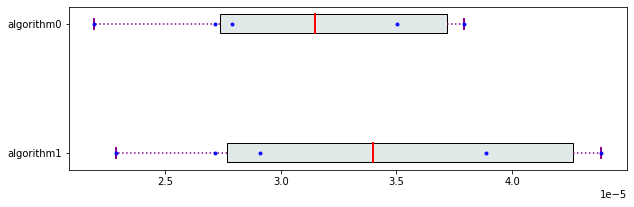

In [65]:
mv.show_measurements_boxplots()

In [66]:
l = ['algorithm0','algorithm1','algorithm2']

In [67]:
data = []
for i, j in enumerate(l):
    data.append([j,i])
rank_h0 = pd.DataFrame(data,columns=['case:concept:name', 'case:mean-rank'])
rank_h0

,case:concept:name,case:mean-rank
0,algorithm0,0
1,algorithm1,1
2,algorithm2,2


In [68]:
mean_rank

,case:concept:name,case:mean-rank
0,algorithm1,0.0
1,algorithm0,0.0


In [69]:
df = mean_rank.merge(rank_h0, on=['case:concept:name'])
x = df.iloc[:,-1].values
y = df.iloc[:,-2].values
x,y

(array([1, 0]), array([0., 0.]))

In [70]:
np.linalg.norm(x-y,2)

1.0

In [45]:
x = np.array([1,1,1,2,2,2])

In [46]:
x

array([1, 1, 1, 2, 2, 2])

In [52]:
xc= np.convolve(x,[1,-1],'valid')
xc

array([0, 0, 1, 0, 0])

In [54]:
y = np.array([1,1,2,3,3,3])

In [55]:
yc = np.convolve(y,[1,-1],'valid')
yc

array([0, 1, 1, 0, 0])

In [56]:
np.linalg.norm(x-y,2)

2.0

In [71]:
np.linalg.norm(xc-yc,2)/5.

0.2